In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models , transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import torchvision
import numpy as np
import time


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)



Using device: cuda


In [3]:
# Data Augmentation and Normalization
image_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2,contrast=0.2),
    transforms.RandomRotation(10),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406),std=(0.229, 0.224, 0.225))]    
)

In [4]:
# Dataset and DataLoader
dataset_path = dataset_path = r"C:\Data_Learnings\Internship2\FreshHarvest_Dataset\FRUIT-16K"
dataset = datasets.ImageFolder(dataset_path,transform=image_transform)
len(dataset)

16000

In [5]:
dataset.classes

['F_Banana',
 'F_Lemon',
 'F_Lulo',
 'F_Mango',
 'F_Orange',
 'F_Strawberry',
 'F_Tamarillo',
 'F_Tomato',
 'S_Banana',
 'S_Lemon',
 'S_Lulo',
 'S_Mango',
 'S_Orange',
 'S_Strawberry',
 'S_Tamarillo',
 'S_Tomato']

In [6]:
num_classes = len(dataset.classes)
num_classes

16

In [7]:
train_size = int(0.7 * len(dataset))
val_size   = int(0.15 * len(dataset))
test_size  = len(dataset) - train_size - val_size
from torch.utils.data import random_split
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size]) # splitting the image dataset into training and validataion dataset

In [8]:
print(len(train_dataset), len(val_dataset), len(test_dataset))


11200 2400 2400


In [9]:
## Data spliiting into training, validation and testing dataset
train_loader = DataLoader(train_dataset,batch_size=32,shuffle=True) # saving the images in train_loader
val_loader = DataLoader(val_dataset,batch_size=32,shuffle=True) 
test_loader = DataLoader(test_dataset,batch_size=32,shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.7522904].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.0996952].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.7685405].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5702832].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.2042983].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.0713727].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.04

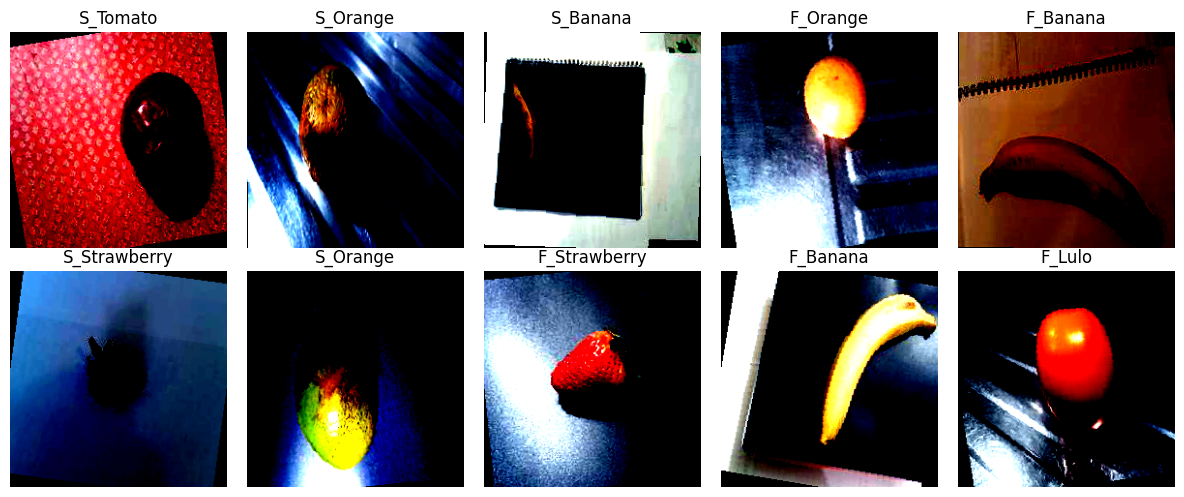

In [10]:
## Data Visualization

images, labels = next(iter(train_loader))

fig, axes = plt.subplots(2, 5, figsize=(12, 5))

for i, ax in enumerate(axes.flatten()):
    img = images[i].permute(1, 2, 0)
    ax.imshow(img)
    ax.set_title(dataset.classes[labels[i]]
)
    ax.axis("off")

plt.tight_layout()
plt.show()


In [11]:
for images,labels in train_loader:
    print(images.shape) # torch.Size([32, 3, 224, 224]) → batch of 32 images, each with 3 color channels and size 224x224
    print(labels.shape)  # torch.Size([32]) → batch of 32 labels
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [12]:
images[31],labels[31]


(tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044,

In [13]:
class FruitClassifier(nn.Module):
    def __init__(self,num_classes):
        super(FruitClassifier,self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3,stride = 1,padding=1), # (16,224,224) #Without padding, image size shrinks.
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0), # (16,112,112) #stride=2 means we are taking 2 steps at a time, so the image size is reduced by half.
            nn.Conv2d(16,32,kernel_size=3,stride = 1,padding=1), # (32,112,112) #Without padding, image size shrinks.
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0), # (32,56,56)
            nn.Conv2d(32,64,kernel_size=3,stride = 1,padding=1), # (64,56,56) #Without padding, image size shrinks.
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0), # (64,28,28)
            nn.Flatten(),
            nn.Linear(64*28*28,512),
            nn.ReLU(),
            nn.Linear(512,num_classes)
        )



    def forward(self,x):
         x = self.network(x)  
         return x     

In [14]:
model = FruitClassifier(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)

In [ ]:
def train(model,train_loader,val_loader,test_loader,criterion,optimizer,num_epochs):
    start = time.time()
    model.train() # set the model to training mode
    running_loss = 0.0
    for epoch in range(num_epochs):
        for batch_num,(images,labels) in enumerate(train_loader):
            images,labels = images.to(device),labels.to(device)

            # zero the gradient parameter 
            optimizer.zero_grad()
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs,labels)
            # Backward pass and optimization
            loss.backward() # AVERAGE LOSS FOR BATCH OF 32 IMAGES
            optimizer.step()
            if (batch_num+1) % 10 == 0: # print loss every 10 batches
                print(f"Epoch {epoch+1}, Batch {batch_num+1}, Loss: {loss.item():.4f}")
            running_loss += loss.item() * images.size(0) # AGGREGATION OF TOTAL LOSS FOR THE BATCH OF 32 IMAGES
    epoch_loss = running_loss / len(train_loader.dataset) # AVERAGE LOSS PER IMAGE
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
    ## validation
    model.eval() # set the model to evaluation mode
    correct = 0
    total = 0       
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for images,labels in val_loader:
            images,labels = images.to(device),labels.to(device)
            outputs = model(images)
            _,predicted = torch.max(outputs.data,1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy()) # GPU tensors cannot be converted directly to NumPy
            all_predictions.extend(predicted.cpu().numpy())
        print(f"Validation Accuracy: {100 * correct / total:.2f}%")
    end = time.time()
    print(f"Training and validation completed in {end - start:.2f} seconds.")
    # ---------- TEST EVALUATION ----------
    model.eval()
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_accuracy = 100 * correct_test / total_test
    print(f"Test Accuracy: {test_accuracy:.2f}%")

    return all_labels,all_predictions  

In [16]:
train(model,train_loader,val_loader,test_loader,criterion,optimizer,num_epochs=15)

Epoch 1, Batch 10, Loss: 2.7491
Epoch 1, Batch 20, Loss: 2.5478
Epoch 1, Batch 30, Loss: 2.4511
Epoch 1, Batch 40, Loss: 2.2875
Epoch 1, Batch 50, Loss: 1.7940
Epoch 1, Batch 60, Loss: 1.8973
Epoch 1, Batch 70, Loss: 1.4830
Epoch 1, Batch 80, Loss: 1.8699
Epoch 1, Batch 90, Loss: 1.7978
Epoch 1, Batch 100, Loss: 1.7856
Epoch 1, Batch 110, Loss: 1.4402
Epoch 1, Batch 120, Loss: 1.1519
Epoch 1, Batch 130, Loss: 1.5985
Epoch 1, Batch 140, Loss: 1.1644
Epoch 1, Batch 150, Loss: 1.0121
Epoch 1, Batch 160, Loss: 1.0822
Epoch 1, Batch 170, Loss: 1.4267
Epoch 1, Batch 180, Loss: 0.8698
Epoch 1, Batch 190, Loss: 1.1545
Epoch 1, Batch 200, Loss: 1.1501
Epoch 1, Batch 210, Loss: 1.0997
Epoch 1, Batch 220, Loss: 1.1263
Epoch 1, Batch 230, Loss: 0.8461
Epoch 1, Batch 240, Loss: 1.1185
Epoch 1, Batch 250, Loss: 1.2109
Epoch 1, Batch 260, Loss: 0.7915
Epoch 1, Batch 270, Loss: 0.8961
Epoch 1, Batch 280, Loss: 0.7107
Epoch 1, Batch 290, Loss: 0.7619
Epoch 1, Batch 300, Loss: 1.4443
Epoch 1, Batch 310,

([np.int64(1),
  np.int64(13),
  np.int64(1),
  np.int64(14),
  np.int64(2),
  np.int64(14),
  np.int64(5),
  np.int64(7),
  np.int64(2),
  np.int64(2),
  np.int64(4),
  np.int64(15),
  np.int64(15),
  np.int64(3),
  np.int64(3),
  np.int64(5),
  np.int64(12),
  np.int64(5),
  np.int64(2),
  np.int64(1),
  np.int64(0),
  np.int64(15),
  np.int64(5),
  np.int64(7),
  np.int64(3),
  np.int64(8),
  np.int64(7),
  np.int64(8),
  np.int64(2),
  np.int64(7),
  np.int64(14),
  np.int64(7),
  np.int64(9),
  np.int64(10),
  np.int64(7),
  np.int64(15),
  np.int64(1),
  np.int64(8),
  np.int64(6),
  np.int64(10),
  np.int64(11),
  np.int64(4),
  np.int64(4),
  np.int64(11),
  np.int64(3),
  np.int64(0),
  np.int64(6),
  np.int64(9),
  np.int64(9),
  np.int64(4),
  np.int64(0),
  np.int64(14),
  np.int64(15),
  np.int64(11),
  np.int64(0),
  np.int64(2),
  np.int64(7),
  np.int64(12),
  np.int64(1),
  np.int64(10),
  np.int64(1),
  np.int64(1),
  np.int64(14),
  np.int64(8),
  np.int64(9),
  np.i